# Toxic comments classification challenge

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import sklearn
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud

## Data exploration

In [38]:
train_df = pd.read_csv('C:/Users/lilia/OneDrive/Documents/S2 ENSAE/NLP/Project/train.csv')

In [39]:
test_df = pd.read_csv('C:/Users/lilia/OneDrive/Documents/S2 ENSAE/NLP/Project/test.csv')

In [40]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [41]:
train_df.shape

(159571, 8)

In [42]:
train_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [43]:
train_df.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [44]:
train_df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,159571,159571,04a4c4f00da26b55,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comment_text,159571,159571,then you must prove it...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toxic,159571,NaN,NaN,NaN,0.0958445,0.294379,0,0,0,0,1
severe_toxic,159571,NaN,NaN,NaN,0.00999555,0.0994771,0,0,0,0,1
obscene,159571,NaN,NaN,NaN,0.0529482,0.223931,0,0,0,0,1
threat,159571,NaN,NaN,NaN,0.00299553,0.0546496,0,0,0,0,1
insult,159571,NaN,NaN,NaN,0.0493636,0.216627,0,0,0,0,1
identity_hate,159571,NaN,NaN,NaN,0.00880486,0.0934205,0,0,0,0,1


In [45]:
print("Check for missing values in Train dataset")
print(train_df.isnull().sum())
print()
print("Check for missing values in Test dataset")
print(test_df.isnull().sum())

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64


## Data visualization

In [46]:
types = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [47]:
x=train_df.iloc[:,2:].sum()

rowsums=train_df.iloc[:,2:].sum(axis=1)
train_df['clean']=(rowsums==0)

train_df['clean'].sum()
print("Total comments = ",len(train_df))
print("Total clean comments = ",train_df['clean'].sum())
print("Total toxic comments = ",len(train_df[train_df['clean']!=1]))
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total toxic comments =  16225
Total tags = 35098


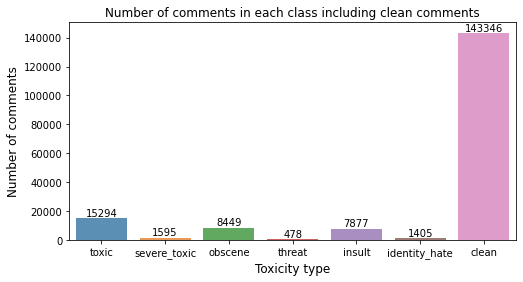

In [48]:
x = train_df.iloc[:,2:].sum()

plt.figure(figsize=(8,4))
ax= sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Number of comments in each class including clean comments")
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Toxicity type', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

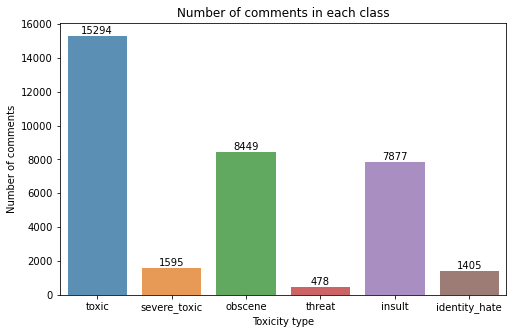

In [49]:
val_counts = train_df[types].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(x=val_counts.index, y=val_counts.values, alpha=0.8)

plt.title("Number of comments in each class")
plt.xlabel("Toxicity type")
plt.ylabel("Number of comments")

rects = ax.patches
labels = val_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha="center", va="bottom")
    
plt.show()

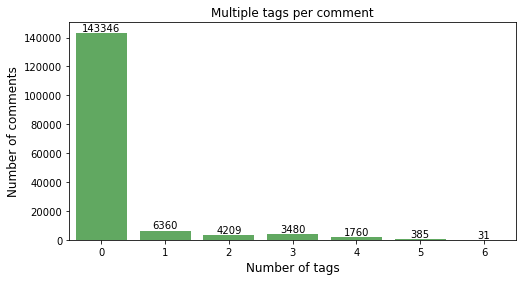

In [50]:
x=rowsums.value_counts()

plt.figure(figsize=(8,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of tags', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

<AxesSubplot:>

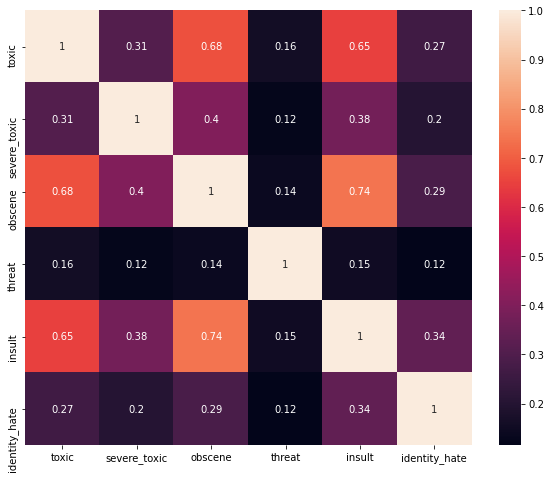

In [51]:
temp_df = train_df.iloc[:,2:-1]
corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [52]:
# Comments in capitals
train_df['capitals'] = train_df['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper()))

# Number of punctuations in comments
train_df['punctuations'] = train_df['comment_text'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

# Number of emojis in comments
emojis = (':-)', ':)', ';-)', ';)')
train_df['emojis'] = train_df['comment_text'].apply(lambda comment: sum(comment.count(s) for s in emojis))

In [53]:
# Number of characters in comments
train_df['length'] = train_df['comment_text'].apply(len)
test_df['length'] = test_df['comment_text'].apply(len)

# Number of sentences
train_df['sentences'] = train_df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
test_df['sentences'] = test_df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)

# Number of words
train_df['words'] = train_df["comment_text"].apply(lambda x: len(str(x).split()))
test_df['words'] = test_df["comment_text"].apply(lambda x: len(str(x).split()))

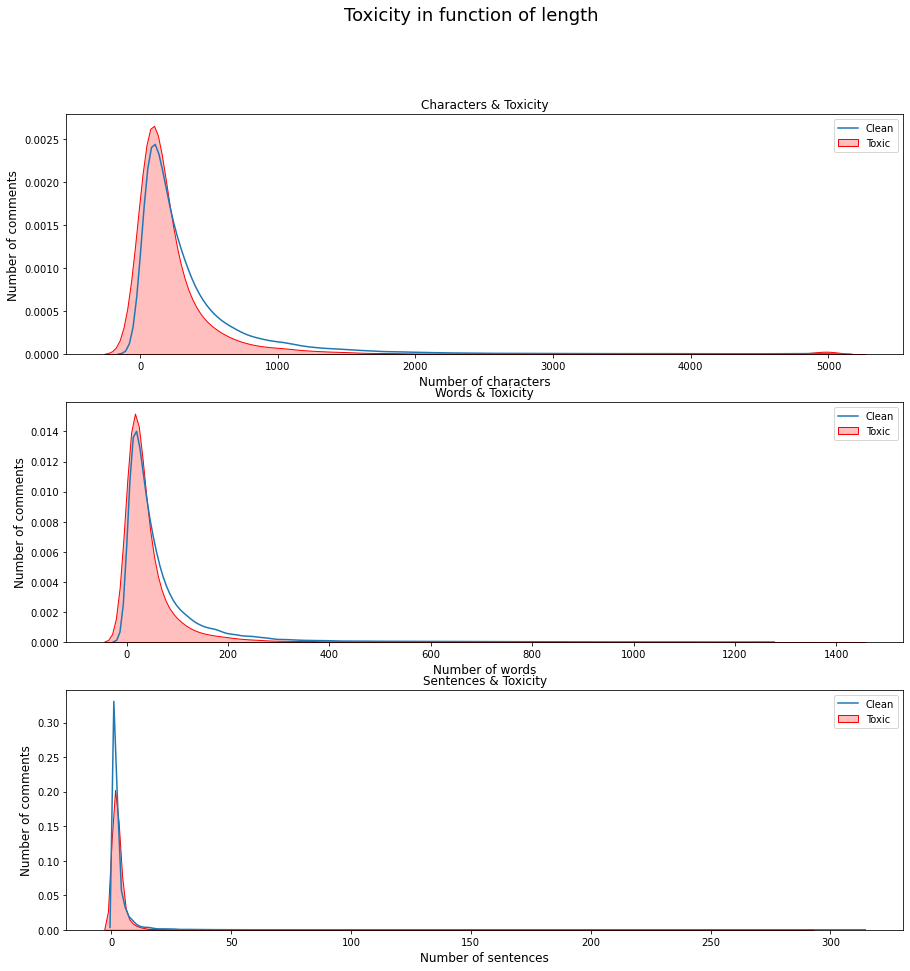

In [61]:
plt.figure(figsize=(15,15))
plt.suptitle("Toxicity in function of length",fontsize=18)
plt.tight_layout()

# Number of characters
plt.subplot(311)
ax=sns.kdeplot(train_df[train_df.clean == 0].length, label="Toxic",shade=True,color='r')
ax=sns.kdeplot(train_df[train_df.clean == 1].length, label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of characters', fontsize=12)
plt.title("Characters & Toxicity", fontsize=12)

# Number of words
plt.subplot(312)
ax=sns.kdeplot(train_df[train_df.clean == 0].words, label="Toxic",shade=True,color='r')
ax=sns.kdeplot(train_df[train_df.clean == 1].words, label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of words', fontsize=12)
plt.title("Words & Toxicity", fontsize=12)

# Number of sentences
plt.subplot(313)
ax=sns.kdeplot(train_df[train_df.clean == 0].sentences, label="Toxic",shade=True,color='r')
ax=sns.kdeplot(train_df[train_df.clean == 1].sentences, label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of sentences', fontsize=12)
plt.title("Sentences & Toxicity", fontsize=12)

plt.show()

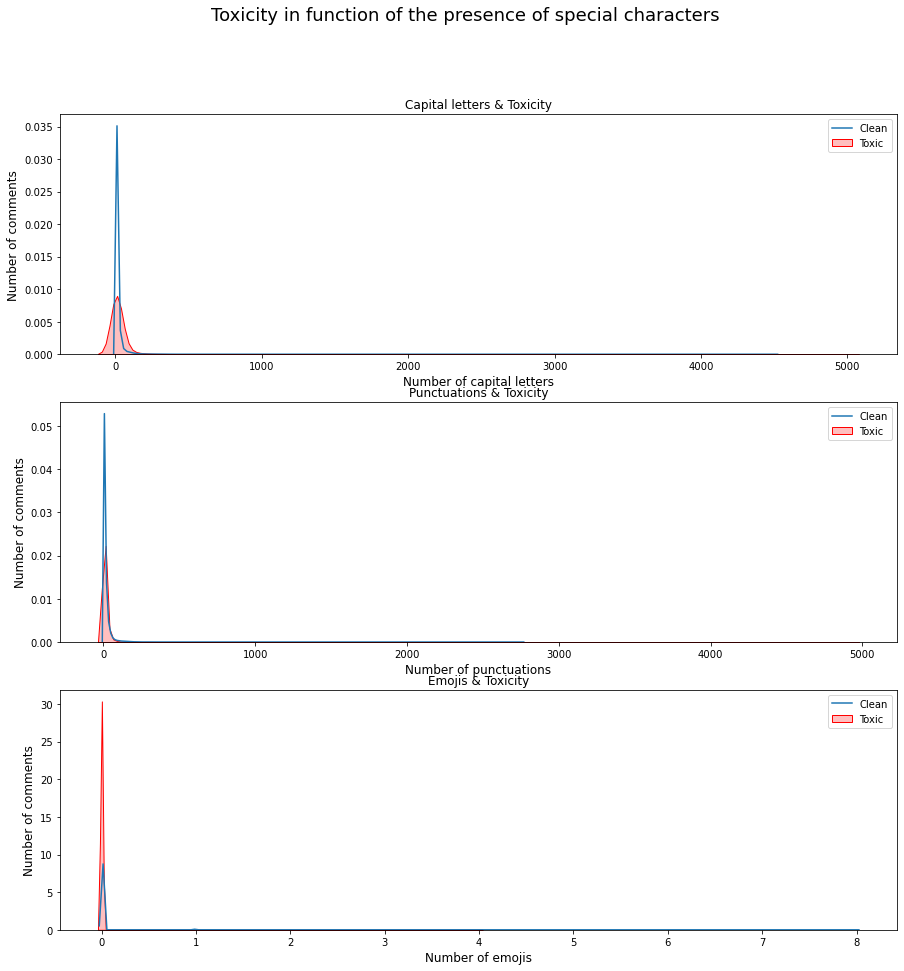

In [60]:
plt.figure(figsize=(15,15))
plt.suptitle("Toxicity in function of the presence of special characters",fontsize=18)
plt.tight_layout()

plt.subplot(311)
ax=sns.kdeplot(train_df[train_df.clean == 0].capitals, label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df[train_df.clean == 1].capitals, label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of capital letters', fontsize=12)
plt.title("Capital letters & Toxicity", fontsize=12)

plt.subplot(312)
ax=sns.kdeplot(train_df[train_df.clean == 0].punctuations, label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df[train_df.clean == 1].punctuations, label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of punctuations', fontsize=12)
plt.title("Punctuations & Toxicity", fontsize=12)

plt.subplot(313)
ax=sns.kdeplot(train_df[train_df.clean == 0].emojis, label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df[train_df.clean == 1].emojis, label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of emojis', fontsize=12)
plt.title("Emojis & Toxicity", fontsize=12)

plt.show()

## Data pre-processing

In [62]:
train_df["clean_comments"] = train_df["comment_text"].apply(lambda x: x.lower())

In [63]:
def remove_URL(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)

def remove_html(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7f]',r'', text)

def remove_special_characters(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F' 
        u'\U0001F300-\U0001F5FF'  
        u'\U0001F680-\U0001F6FF'  
        u'\U0001F1E0-\U0001F1FF' 
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [64]:
train_df["clean_comments"] = train_df["clean_comments"].apply(lambda x: remove_URL(x))

In [65]:
train_df["clean_comments"] = train_df["clean_comments"].apply(lambda x: remove_html(x))

In [66]:
train_df["clean_comments"] = train_df["clean_comments"].apply(lambda x: remove_non_ascii(x))

In [67]:
train_df["clean_comments"] = train_df["clean_comments"].apply(lambda x: remove_special_characters(x))

In [68]:
train_df["clean_comments"] = train_df["clean_comments"].apply(lambda x: remove_punct(x))

In [69]:
stop = set(stopwords.words('english'))
train_df['clean_comments'] = train_df['clean_comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

In [70]:
word_counter = {}

for categ in types:
    d = Counter()
    train_df[train_df[categ] == 1]['clean_comments'].apply(lambda t: d.update(t.split()))
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

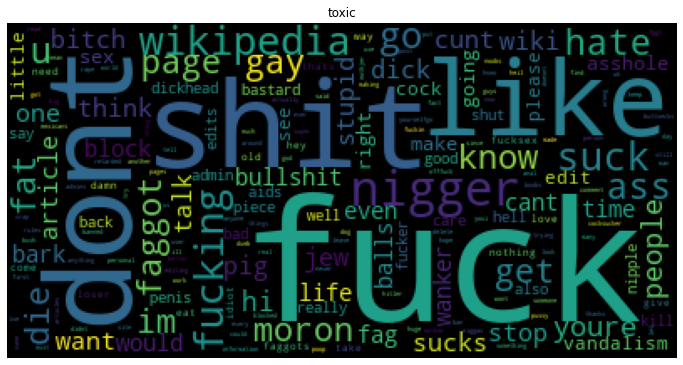

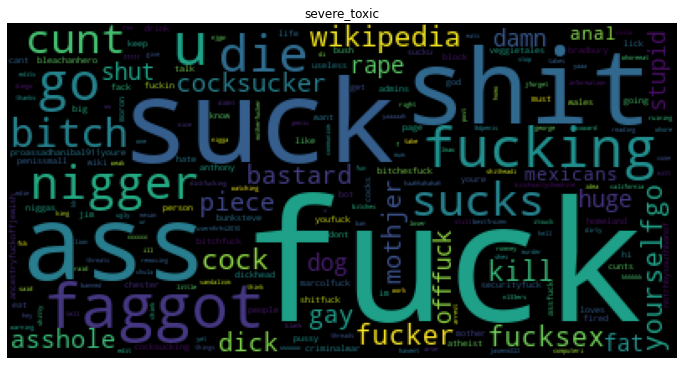

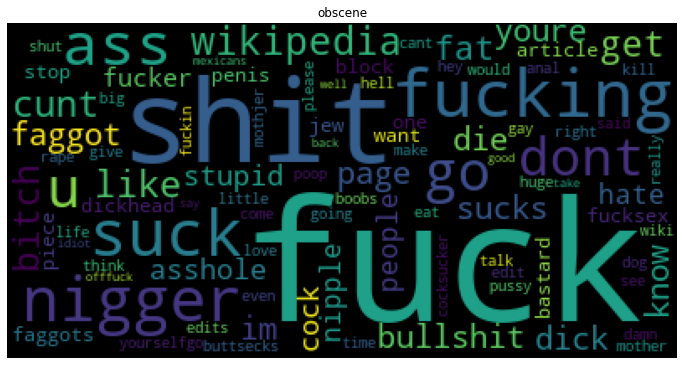

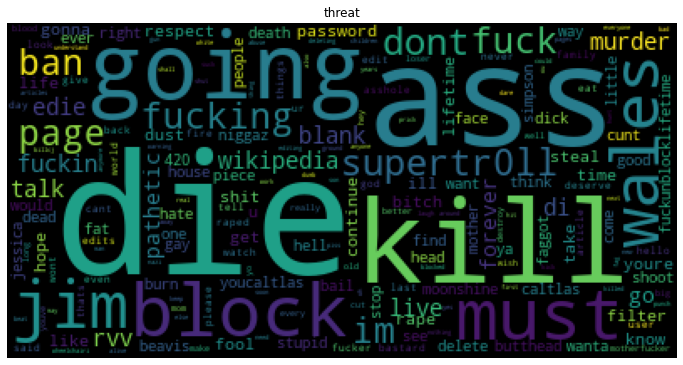

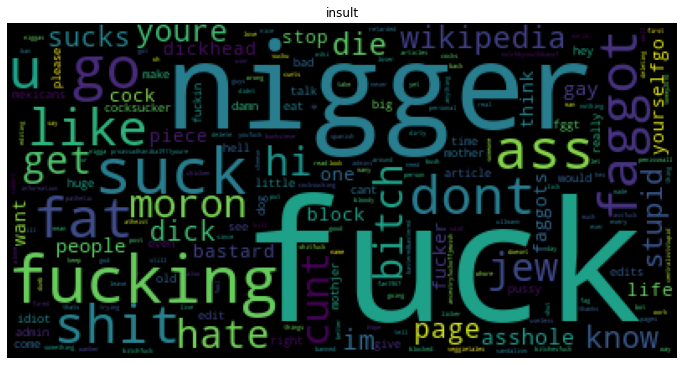

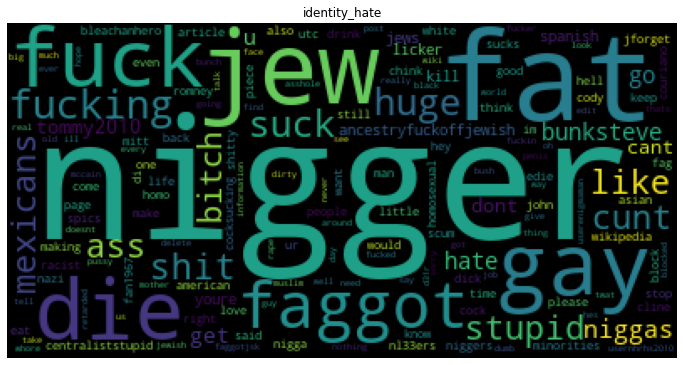

In [71]:
for w in word_counter:
    wc = word_counter[w]

    wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

    fig = plt.figure(figsize=(12, 8))
    plt.title(w)
    plt.imshow(wordcloud)
    plt.axis('off')

In [ ]:
train_df['tokenized_comments'] = train_df['clean_comments'].apply(word_tokenize)

In [ ]:
def porter_stemmer(text):
    stemmer = nltk.PorterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

In [ ]:
#train_df['stemmed_text'] = train_df['tokenized_comments'].apply(lambda x: porter_stemmer(x))